In [1]:
import os
import sys
import time
import argparse
import plotly.express as px
import numpy as np
import pandas as pd
import zipfile
import fnmatch
import flirt.reader.empatica
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [2]:
import zipfile,fnmatch,os
rootPath = r"./"
pattern = '*.zip'
for root, dirs, files in os.walk(rootPath):
    for filename in fnmatch.filter(files, pattern):
        print(os.path.join(root, filename))
        zipfile.ZipFile(os.path.join(root, filename)).extractall(os.path.join(root, os.path.splitext(filename)[0]))

./061821_A02078.zip
./061921_A02078.zip
./062021_A02078.zip
./062121_A02078.zip
./062221_A02078.zip
./062321_A02078.zip


# HRV


In [3]:

import flirt.reader.empatica
ibis = flirt.reader.empatica.read_ibi_file_into_df('./062021_A02078/IBI.csv')
hrv_features = flirt.get_hrv_features(ibis['ibi'], 128, 1, ["td", "fd", "stat"], 0.2)
hrv_features = hrv_features.dropna(how='any',axis=0)
hrv_features.reset_index(inplace=True)
hrv_features["Unix_timestamp"] = hrv_features["datetime"].apply(lambda x: pd.Timestamp(x).timestamp())
# hrv_features


HRV features: 100%|██████████| 51718/51718 [00:26<00:00, 1930.77it/s]


Unable to remove memmapped file


In [4]:
hrv_features.shape, len(hrv_features)

((40723, 48), 40723)

In [5]:
hrv_features['Index'] = np.arange(len(hrv_features))

In [6]:
hrv_features['Index']

0            0
1            1
2            2
3            3
4            4
         ...  
40718    40718
40719    40719
40720    40720
40721    40721
40722    40722
Name: Index, Length: 40723, dtype: int32

In [7]:
def moving_avarage_smoothing(X,k):
	S = np.zeros(X.shape[0])
	for t in tqdm(range(X.shape[0])):
		if t < k:
			S[t] = np.mean(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S

MAG_K300  = moving_avarage_smoothing(hrv_features['hrv_rmssd'], 500)
hrv_features['MAG_K300'] = MAG_K300
mean_rmssd = hrv_features['hrv_rmssd'].mean()
std_rmssd = hrv_features['hrv_rmssd'].std()
fig = px.line(hrv_features, y='MAG_K300', x = 'datetime')
fig.add_hline(y=mean_rmssd, annotation_text="Mean RMSSD",  annotation_position="bottom right")
fig.add_hline(y=std_rmssd, annotation_text="STD RMSSD",  annotation_position="bottom right")
fig.show()


  0%|          | 0/40723 [00:00<?, ?it/s]

In [8]:
def Starting_timeStamp(column, time_frames):
    starting_time_index = []
    for i in range(len(column)-1):
        if column[i] < mean_rmssd and column[i+1] > mean_rmssd:
            starting_time_index.append(time_frames[i])
    return starting_time_index
    
    
hrv_starting_timestamp = Starting_timeStamp(hrv_features['MAG_K300'], hrv_features['datetime'])
# index_of_starting_timestamp = Starting_timeStamp(hrv_features['MAG_K300'], hrv_features['Index'])

def Ending_timeStamp(column, time_frames):
    time_index = []
    for i in range(len(column)-1):
        if column[i] > mean_rmssd and column[i+1] < mean_rmssd:
            time_index.append(time_frames[i])
    if column[len(column) -1 ] > mean_rmssd:
        time_index.insert(len(time_index), time_frames[len(time_frames) -1])
    else:
        pass        
    return time_index

hrv_ending_timestamp = Ending_timeStamp(hrv_features['MAG_K300'], hrv_features['datetime'])
# index_of_ending_timestamp = Ending_timeStamp(hrv_features['MAG_K300'], hrv_features['Index'])

if hrv_starting_timestamp > hrv_ending_timestamp:
    hrv_ending_timestamp.pop(0)
else:
    pass

print(hrv_starting_timestamp)
print(hrv_ending_timestamp)


[Timestamp('2021-06-20 12:04:48+0000', tz='UTC'), Timestamp('2021-06-20 12:20:49+0000', tz='UTC'), Timestamp('2021-06-20 13:20:09+0000', tz='UTC'), Timestamp('2021-06-20 13:32:32+0000', tz='UTC'), Timestamp('2021-06-20 13:35:24+0000', tz='UTC'), Timestamp('2021-06-20 13:45:30+0000', tz='UTC'), Timestamp('2021-06-20 13:50:14+0000', tz='UTC'), Timestamp('2021-06-20 13:56:42+0000', tz='UTC'), Timestamp('2021-06-20 14:13:06+0000', tz='UTC'), Timestamp('2021-06-20 14:46:01+0000', tz='UTC'), Timestamp('2021-06-20 15:02:08+0000', tz='UTC'), Timestamp('2021-06-20 15:17:22+0000', tz='UTC'), Timestamp('2021-06-20 16:21:12+0000', tz='UTC'), Timestamp('2021-06-20 16:50:19+0000', tz='UTC'), Timestamp('2021-06-20 17:20:33+0000', tz='UTC'), Timestamp('2021-06-20 17:53:27+0000', tz='UTC'), Timestamp('2021-06-20 18:02:04+0000', tz='UTC'), Timestamp('2021-06-20 18:08:35+0000', tz='UTC'), Timestamp('2021-06-20 19:37:19+0000', tz='UTC'), Timestamp('2021-06-20 20:30:19+0000', tz='UTC'), Timestamp('2021-06-

In [9]:
difference = [] # initialization of result list
time_delta_minutes = []
desired_time_index = []
zip_object = zip(hrv_ending_timestamp, hrv_starting_timestamp)

for list1_i, list2_i in zip_object:
    difference.append(list1_i-list2_i)# append each difference to list
for i in difference:
    time_delta_minutes.append(i.total_seconds()/60)
time_delta_minutes

for i in range(len(time_delta_minutes)):
    if time_delta_minutes[i] > 5.00:
        desired_time_index.append(i)
print(time_delta_minutes, '\n' )
desired_time_index


[3.9, 47.5, 8.316666666666666, 1.4, 6.533333333333333, 0.6166666666666667, 2.466666666666667, 9.716666666666667, 27.883333333333333, 15.016666666666667, 2.3, 28.566666666666666, 12.516666666666667, 20.383333333333333, 8.733333333333333, 4.05, 1.1333333333333333, 9.716666666666667, 11.05, 19.516666666666666, 4.6, 17.483333333333334, 4.416666666666667, 1.3, 133.96666666666667, 0.1, 1.95, 30.1] 



[1, 2, 4, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 21, 24, 27]

In [10]:
hrv_starting_timestamp_df = pd.DataFrame(hrv_starting_timestamp)
hrv_ending_timestamp_df = pd.DataFrame(hrv_ending_timestamp)
frames = (hrv_starting_timestamp_df, hrv_ending_timestamp_df)
hrv_events_df = pd.concat(frames,  axis=1)
hrv_events_df.columns = ['Starting Timestamp', 'Ending Timestamp']
hrv_events_df = hrv_events_df.loc[desired_time_index, :]
hrv_events_df = hrv_events_df.reset_index(drop = True)

# import logging
# import datetime
# def join_smaller_events(feature):
#     try:
#         for i in range(len(feature['Starting Timestamp'])):
#             # print(hr_events_df['Starting Timestamp'][i+1])
#             for j in range(len(feature['Ending Timestamp'])):
#                 if ((feature['Starting Timestamp'][i+1] - feature['Ending Timestamp'][i]) < datetime.timedelta(minutes=10) and 
#                     (feature['Starting Timestamp'][i+1] - feature['Ending Timestamp'][i]) > datetime.timedelta(minutes=0, seconds=0)):
#                     feature['Starting Timestamp'][i+1] = feature['Ending Timestamp'][i]
#                         # print(hr_events_df['Starting Timestamp'][i+1], '\n', hr_events_df['Ending Timestamp'][i]) 
#                 else:
#                     pass        
#     except KeyError as error:
#         logging.info('range error in delta time adjustments')
    
# join_smaller_events(hrv_events_df)

hrv_events_df


Starting Timestamp          Ending Timestamp
0  2021-06-20 12:20:49+00:00 2021-06-20 13:08:19+00:00
1  2021-06-20 13:20:09+00:00 2021-06-20 13:28:28+00:00
2  2021-06-20 13:35:24+00:00 2021-06-20 13:41:56+00:00
3  2021-06-20 13:56:42+00:00 2021-06-20 14:06:25+00:00
4  2021-06-20 14:13:06+00:00 2021-06-20 14:40:59+00:00
5  2021-06-20 14:46:01+00:00 2021-06-20 15:01:02+00:00
6  2021-06-20 15:17:22+00:00 2021-06-20 15:45:56+00:00
7  2021-06-20 16:21:12+00:00 2021-06-20 16:33:43+00:00
8  2021-06-20 16:50:19+00:00 2021-06-20 17:10:42+00:00
9  2021-06-20 17:20:33+00:00 2021-06-20 17:29:17+00:00
10 2021-06-20 18:08:35+00:00 2021-06-20 18:18:18+00:00
11 2021-06-20 19:37:19+00:00 2021-06-20 19:48:22+00:00
12 2021-06-20 20:30:19+00:00 2021-06-20 20:49:50+00:00
13 2021-06-20 21:20:57+00:00 2021-06-20 21:38:26+00:00
14 2021-06-20 22:41:12+00:00 2021-06-21 00:55:10+00:00
15 2021-06-21 01:04:06+00:00 2021-06-21 01:34:12+00:00

In [11]:
# starting_time_indices = []
# for i in range(len(hrv_events_df['Starting Timestamp'])):
#     starting_time_indices.append(int(hrv_features[hrv_features['datetime']== hrv_events_df['Starting Timestamp'][i]].index.values))

# ending_time_indices = []
# for i in range(len(hrv_events_df['Ending Timestamp'])):
#     ending_time_indices.append(int(hrv_features[hrv_features['datetime']== hrv_events_df['Ending Timestamp'][i]].index.values))

# starting_time_indices, ending_time_indices


In [12]:
# hrv_events = pd.DataFrame()
# i = 1
# # x  = (hrv_features['datetime'][starting_time_indices[0] : ending_time_indices[0]].values)
# hrv_events[0] = (hrv_features['datetime'][starting_time_indices[27] : ending_time_indices[27]].values)
# hrv_events




In [13]:
# import logging
# # hrv_events = pd.DataFrame(index=None)
# hrv_events = pd.DataFrame()

# try:
#     k = 0
#     for i in range(len(starting_time_indices)):
#         for j in range(len(ending_time_indices)):
#             hrv_events[k] = pd.Series(hrv_features['datetime'][starting_time_indices[i] : ending_time_indices[j]].values)
#             # print(hrv_features['datetime'][starting_time_indices[i] : ending_time_indices[j]])
#             # pd.concat(hrv_events, axis=1)
#             # hrv_events = pd.concat(hrv_features['datetime'][starting_time_indices[i] : ending_time_indices[j]], axis=1)
#             i += 1
#             j += 1
#             k += 1
# except IndexError as error:
#     logging.info('this error can be avoided')
        
# hrv_events = pd.DataFrame()
# for i in range(len(starting_time_indices)):
#     for j in range(len(ending_time_indices)):
#         hrv_events = (hrv_features['datetime'][starting_time_indices[i] : ending_time_indices[j]])
#         i += 1
#         j += 1


In [14]:
# hrv_events

# heart rate

In [15]:
hr_df = flirt.reader.empatica.read_hr_file_into_df("./062021_A02078/HR.csv")
hr_df.reset_index(inplace=True)
hr_df

datetime     hr
0     2021-06-20 11:10:04+00:00  61.00
1     2021-06-20 11:10:05+00:00  61.00
2     2021-06-20 11:10:06+00:00  61.00
3     2021-06-20 11:10:07+00:00  58.00
4     2021-06-20 11:10:08+00:00  60.40
...                         ...    ...
52074 2021-06-21 01:37:58+00:00  73.58
52075 2021-06-21 01:37:59+00:00  73.40
52076 2021-06-21 01:38:00+00:00  73.23
52077 2021-06-21 01:38:01+00:00  73.12
52078 2021-06-21 01:38:02+00:00  72.95

[52079 rows x 2 columns]

In [16]:
def moving_avarage_smoothing(X,k):
	S = np.zeros(X.shape[0])
	for t in tqdm(range(X.shape[0])):
		if t < k:
			S[t] = np.mean(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S

MAG_K300  = moving_avarage_smoothing(hr_df['hr'], 500)
hr_df['MAG_K300'] = MAG_K300
mean_hr = hr_df['hr'].mean()
std_hr = hr_df['hr'].std()
fig = px.line(hr_df, y='MAG_K300', x = 'datetime')
fig.add_hline(y=mean_hr, annotation_text="Mean HR",  annotation_position="bottom right")
fig.add_hline(y=std_hr, annotation_text="STD HR",  annotation_position="bottom right")
fig.show()

  0%|          | 0/52079 [00:00<?, ?it/s]

In [17]:
def Starting_timeStamp(column, time_frames):
    starting_time_index = []
    for i in range(len(column)-1):
        if column[i] < mean_hr and column[i+1] > mean_hr:
            starting_time_index.append(time_frames[i])
    return starting_time_index
    
    
# index_of_starting_timestamp = Starting_timeStamp(hrv_features['MAG_K300'], hrv_features['Index'])

def Ending_timeStamp(column, time_frames):
    time_index = []
    for i in range(len(column)-1):
        if column[i] > mean_hr and column[i+1] < mean_hr:
            time_index.append(time_frames[i])
    if column[len(column) -1 ] > mean_hr:
        time_index.insert(len(time_index), time_frames[len(time_frames) -1])
    else:
        pass        
    return time_index


hr_starting_timestamp = Starting_timeStamp(hr_df['MAG_K300'], hr_df['datetime'])
hr_ending_timestamp = Ending_timeStamp(hr_df['MAG_K300'], hr_df['datetime'])
# index_of_ending_timestamp = Ending_timeStamp(hr_df['MAG_K300'], hr_df['datetime'])

if hr_starting_timestamp > hr_ending_timestamp:
    hr_ending_timestamp.pop(0)
else:
    pass

print(hr_starting_timestamp)
print(hr_ending_timestamp)


[Timestamp('2021-06-20 11:47:43+0000', tz='UTC'), Timestamp('2021-06-20 12:06:58+0000', tz='UTC'), Timestamp('2021-06-20 15:18:55+0000', tz='UTC'), Timestamp('2021-06-20 17:05:45+0000', tz='UTC'), Timestamp('2021-06-20 17:31:03+0000', tz='UTC'), Timestamp('2021-06-20 17:47:25+0000', tz='UTC'), Timestamp('2021-06-20 18:02:59+0000', tz='UTC'), Timestamp('2021-06-20 18:50:12+0000', tz='UTC'), Timestamp('2021-06-20 20:11:57+0000', tz='UTC'), Timestamp('2021-06-20 20:41:38+0000', tz='UTC'), Timestamp('2021-06-20 21:03:01+0000', tz='UTC'), Timestamp('2021-06-20 21:21:02+0000', tz='UTC'), Timestamp('2021-06-20 21:50:36+0000', tz='UTC'), Timestamp('2021-06-20 22:03:42+0000', tz='UTC'), Timestamp('2021-06-20 22:34:16+0000', tz='UTC'), Timestamp('2021-06-20 22:41:29+0000', tz='UTC'), Timestamp('2021-06-20 23:00:55+0000', tz='UTC'), Timestamp('2021-06-20 23:46:42+0000', tz='UTC'), Timestamp('2021-06-21 01:22:59+0000', tz='UTC'), Timestamp('2021-06-21 01:33:29+0000', tz='UTC')]
[Timestamp('2021-06

In [18]:
difference = [] # initialization of result list
time_delta_minutes = []
desired_time_index = []
zip_object = zip(hr_ending_timestamp, hr_starting_timestamp)

for list1_i, list2_i in zip_object:
    difference.append(list1_i-list2_i)# append each difference to list
for i in difference:
    time_delta_minutes.append(i.total_seconds()/60)
time_delta_minutes

for i in range(len(time_delta_minutes)):
    if time_delta_minutes[i] > 5.00:
        desired_time_index.append(i)
print(time_delta_minutes, '\n' )
desired_time_index


[11.883333333333333, 96.75, 36.11666666666667, 3.4, 11.233333333333333, 2.216666666666667, 44.7, 9.716666666666667, 24.016666666666666, 7.683333333333334, 5.616666666666666, 9.166666666666666, 6.566666666666666, 5.9, 6.066666666666666, 1.7833333333333334, 37.28333333333333, 65.41666666666667, 7.25, 2.316666666666667] 



[0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18]

In [19]:
hr_starting_timestamp_df = pd.DataFrame(hr_starting_timestamp)
hr_ending_timestamp_df = pd.DataFrame(hr_ending_timestamp)
frames = (hr_starting_timestamp_df, hr_ending_timestamp_df)
hr_events_df = pd.concat(frames,  axis=1)
hr_events_df.columns = ['Starting Timestamp', 'Ending Timestamp']
hr_events_df = hr_events_df.loc[desired_time_index, :]
hr_events_df = hr_events_df.reset_index(drop=True)

# join_smaller_events(hr_events_df)
hr_events_df

Starting Timestamp          Ending Timestamp
0  2021-06-20 11:47:43+00:00 2021-06-20 11:59:36+00:00
1  2021-06-20 12:06:58+00:00 2021-06-20 13:43:43+00:00
2  2021-06-20 15:18:55+00:00 2021-06-20 15:55:02+00:00
3  2021-06-20 17:31:03+00:00 2021-06-20 17:42:17+00:00
4  2021-06-20 18:02:59+00:00 2021-06-20 18:47:41+00:00
5  2021-06-20 18:50:12+00:00 2021-06-20 18:59:55+00:00
6  2021-06-20 20:11:57+00:00 2021-06-20 20:35:58+00:00
7  2021-06-20 20:41:38+00:00 2021-06-20 20:49:19+00:00
8  2021-06-20 21:03:01+00:00 2021-06-20 21:08:38+00:00
9  2021-06-20 21:21:02+00:00 2021-06-20 21:30:12+00:00
10 2021-06-20 21:50:36+00:00 2021-06-20 21:57:10+00:00
11 2021-06-20 22:03:42+00:00 2021-06-20 22:09:36+00:00
12 2021-06-20 22:34:16+00:00 2021-06-20 22:40:20+00:00
13 2021-06-20 23:00:55+00:00 2021-06-20 23:38:12+00:00
14 2021-06-20 23:46:42+00:00 2021-06-21 00:52:07+00:00
15 2021-06-21 01:22:59+00:00 2021-06-21 01:30:14+00:00

In [20]:
# import datetime
# hr_events_df['Starting Timestamp'][1] - hr_events_df['Ending Timestamp'][0] < datetime.timedelta(minutes = 10)

In [21]:
# # logic to combine smaller intervals of 10 mins 
# try:
#     for i in range(len(hr_events_df['Starting Timestamp'])):
#         # print(hr_events_df['Starting Timestamp'][i+1])
#         for j in range(len(hr_events_df['Ending Timestamp'])):
#             if ((hr_events_df['Starting Timestamp'][i+1] - hr_events_df['Ending Timestamp'][i]) < datetime.timedelta(minutes=10) and 
#                 (hr_events_df['Starting Timestamp'][i+1] - hr_events_df['Ending Timestamp'][i]) > datetime.timedelta(minutes=0, seconds=0)):
#                 hr_events_df['Starting Timestamp'][i+1] = hr_events_df['Ending Timestamp'][i]
#                 # print(hr_events_df['Starting Timestamp'][i+1], '\n', hr_events_df['Ending Timestamp'][i])         
# except KeyError as error:
#     logging.info('range error in delta time adjustments')
        

In [22]:
# if((hrv_events_df['Starting Timestamp'][0] < hr_events_df['Ending Timestamp'][1]) and ((hr_events_df['Starting Timestamp'][1] < hrv_events_df['Ending Timestamp'][0]))):
#     print('overlap' '\n', 'starting time : ', hrv_events_df['Starting Timestamp'][0], '  Ending Time : ', hr_events_df['Ending Timestamp'][1])


In [23]:
# hrv_events_df['Starting Timestamp'][11], hrv_events_df['Ending Timestamp'][11]
# 

In [24]:
# hr_events_df['Starting Timestamp'][2], hr_events_df['Ending Timestamp'][2]

In [25]:

# hrv_diff = hrv_events_df['Ending Timestamp'][11] - hrv_events_df['Starting Timestamp'][11]
# hrv_diff

In [26]:
# hr_diff = hr_events_df['Ending Timestamp'][2] - hr_events_df['Starting Timestamp'][2]
# hr_diff

In [27]:
# c1 = min(hrv_events_df['Starting Timestamp'][11], hr_events_df['Starting Timestamp'][2])
# c1

In [28]:
# c2 = max(hr_events_df['Ending Timestamp'][2], hrv_events_df['Ending Timestamp'][11])
# c2

In [29]:
# Dc = c2-c1
# Dc

In [30]:
# if  (hr_diff+hrv_diff > Dc):
#     print('overlap')

In [87]:
overlapped_events = pd.DataFrame(columns=['Starting Timestamp', 'Ending Timestamp'])
non_overlapped_events = pd.DataFrame(columns= ['Starting Timestamp', 'Ending Timestamp'])
x = []

def check_overlap(feature_1, feature_2):
    k = 0
    for i in range(len(feature_1)):
        for j in range(len(feature_2)):    
            # print(i, j)   
            delta_a = feature_1['Ending Timestamp'][i] - feature_1['Starting Timestamp'][i]
            delta_b = feature_2['Ending Timestamp'][j] - feature_2['Starting Timestamp'][j]
            c1 = min(feature_1['Starting Timestamp'][i], feature_2['Starting Timestamp'][j])
            c2 = max(feature_2['Ending Timestamp'][j], feature_1['Ending Timestamp'][i])
            Dc = c2-c1
            if ((delta_a+delta_b) > Dc):
                # print(i, j)
                # overlapped_events['Starting Timestamp'] = overlapped_events['Starting Timestamp'].append(pd.DataFrame(c1))
                overlapped_events.at[k, 'Starting Timestamp'] = c1
                overlapped_events.at[k, 'Ending Timestamp'] = c2
                feature_1['Starting Timestamp'][i] = None
                feature_1['Ending Timestamp'][i] = None
                feature_2['Starting Timestamp'][j] = None
                feature_2['Ending Timestamp'][j] = None
                
                
                # i += 1
                # j += 1
                k += 1
                # print(c1,"  ", c2, "\n")


check_overlap(hr_events_df, hrv_events_df)
# overlapped_events

# feature_1 = hrv_events_df
# feature_2 = hr_events_df
# i = 0
# j = 1

# delta_a = feature_1['Ending Timestamp'][i] - feature_1['Starting Timestamp'][i]
# delta_b = feature_2['Ending Timestamp'][j] - feature_2['Starting Timestamp'][j]
# c1 = min(feature_1['Starting Timestamp'][i], feature_2['Starting Timestamp'][j])
# c2 = max(feature_2['Ending Timestamp'][j], feature_1['Ending Timestamp'][i])
# Dc = c2-c1
# if ((delta_a+delta_b) > Dc):
#     print(c1,"  ", c2, "\n")


C:\Users\govindd1\AppData\Local\Temp/ipykernel_13308/705499724.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\govindd1\AppData\Local\Temp/ipykernel_13308/705499724.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\govindd1\AppData\Local\Temp/ipykernel_13308/705499724.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\govindd1\AppData\Local\Temp/ipykernel_13308/705499724.py:23: SettingWithCopyWarnin

In [88]:
overlapped_events

Starting Timestamp           Ending Timestamp
0  2021-06-20 12:06:58+00:00  2021-06-20 13:43:43+00:00
1  2021-06-20 15:17:22+00:00  2021-06-20 15:55:02+00:00
2  2021-06-20 18:02:59+00:00  2021-06-20 18:47:41+00:00
3  2021-06-20 20:11:57+00:00  2021-06-20 20:49:50+00:00
4  2021-06-20 21:20:57+00:00  2021-06-20 21:38:26+00:00
5  2021-06-20 22:41:12+00:00  2021-06-21 00:55:10+00:00
6  2021-06-21 01:04:06+00:00  2021-06-21 01:34:12+00:00

In [89]:
hrv_events_df

Starting Timestamp          Ending Timestamp
0                        NaT                       NaT
1  2021-06-20 13:20:09+00:00 2021-06-20 13:28:28+00:00
2  2021-06-20 13:35:24+00:00 2021-06-20 13:41:56+00:00
3  2021-06-20 13:56:42+00:00 2021-06-20 14:06:25+00:00
4  2021-06-20 14:13:06+00:00 2021-06-20 14:40:59+00:00
5  2021-06-20 14:46:01+00:00 2021-06-20 15:01:02+00:00
6                        NaT                       NaT
7  2021-06-20 16:21:12+00:00 2021-06-20 16:33:43+00:00
8  2021-06-20 16:50:19+00:00 2021-06-20 17:10:42+00:00
9  2021-06-20 17:20:33+00:00 2021-06-20 17:29:17+00:00
10                       NaT                       NaT
11 2021-06-20 19:37:19+00:00 2021-06-20 19:48:22+00:00
12                       NaT                       NaT
13                       NaT                       NaT
14                       NaT                       NaT
15                       NaT                       NaT

In [91]:
hrv_events_df.dropna()

Starting Timestamp          Ending Timestamp
1  2021-06-20 13:20:09+00:00 2021-06-20 13:28:28+00:00
2  2021-06-20 13:35:24+00:00 2021-06-20 13:41:56+00:00
3  2021-06-20 13:56:42+00:00 2021-06-20 14:06:25+00:00
4  2021-06-20 14:13:06+00:00 2021-06-20 14:40:59+00:00
5  2021-06-20 14:46:01+00:00 2021-06-20 15:01:02+00:00
7  2021-06-20 16:21:12+00:00 2021-06-20 16:33:43+00:00
8  2021-06-20 16:50:19+00:00 2021-06-20 17:10:42+00:00
9  2021-06-20 17:20:33+00:00 2021-06-20 17:29:17+00:00
11 2021-06-20 19:37:19+00:00 2021-06-20 19:48:22+00:00

In [90]:
hr_events_df

Starting Timestamp          Ending Timestamp
0  2021-06-20 11:47:43+00:00 2021-06-20 11:59:36+00:00
1                        NaT                       NaT
2                        NaT                       NaT
3  2021-06-20 17:31:03+00:00 2021-06-20 17:42:17+00:00
4                        NaT                       NaT
5  2021-06-20 18:50:12+00:00 2021-06-20 18:59:55+00:00
6                        NaT                       NaT
7  2021-06-20 20:41:38+00:00 2021-06-20 20:49:19+00:00
8  2021-06-20 21:03:01+00:00 2021-06-20 21:08:38+00:00
9                        NaT                       NaT
10 2021-06-20 21:50:36+00:00 2021-06-20 21:57:10+00:00
11 2021-06-20 22:03:42+00:00 2021-06-20 22:09:36+00:00
12 2021-06-20 22:34:16+00:00 2021-06-20 22:40:20+00:00
13                       NaT                       NaT
14 2021-06-20 23:46:42+00:00 2021-06-21 00:52:07+00:00
15                       NaT                       NaT

In [92]:
hr_events_df.dropna()

Starting Timestamp          Ending Timestamp
0  2021-06-20 11:47:43+00:00 2021-06-20 11:59:36+00:00
3  2021-06-20 17:31:03+00:00 2021-06-20 17:42:17+00:00
5  2021-06-20 18:50:12+00:00 2021-06-20 18:59:55+00:00
7  2021-06-20 20:41:38+00:00 2021-06-20 20:49:19+00:00
8  2021-06-20 21:03:01+00:00 2021-06-20 21:08:38+00:00
10 2021-06-20 21:50:36+00:00 2021-06-20 21:57:10+00:00
11 2021-06-20 22:03:42+00:00 2021-06-20 22:09:36+00:00
12 2021-06-20 22:34:16+00:00 2021-06-20 22:40:20+00:00
14 2021-06-20 23:46:42+00:00 2021-06-21 00:52:07+00:00

In [95]:

concatnated_frames_1 = pd.concat([hrv_events_df.dropna(), hr_events_df.dropna(), overlapped_events.dropna()])
concatnated_frames_1 = concatnated_frames_1.reset_index(drop=True)
concatnated_frames_1
# concatnated_frames_1

# if concatnated_frames_1['Starting Timestamp'][i] not in overlapped_events['Starting Timestamp'][i]:
#     non_overlapped_events.append(concatnated_frames_1[i])

Starting Timestamp           Ending Timestamp
0   2021-06-20 13:20:09+00:00  2021-06-20 13:28:28+00:00
1   2021-06-20 13:35:24+00:00  2021-06-20 13:41:56+00:00
2   2021-06-20 13:56:42+00:00  2021-06-20 14:06:25+00:00
3   2021-06-20 14:13:06+00:00  2021-06-20 14:40:59+00:00
4   2021-06-20 14:46:01+00:00  2021-06-20 15:01:02+00:00
5   2021-06-20 16:21:12+00:00  2021-06-20 16:33:43+00:00
6   2021-06-20 16:50:19+00:00  2021-06-20 17:10:42+00:00
7   2021-06-20 17:20:33+00:00  2021-06-20 17:29:17+00:00
8   2021-06-20 19:37:19+00:00  2021-06-20 19:48:22+00:00
9   2021-06-20 11:47:43+00:00  2021-06-20 11:59:36+00:00
10  2021-06-20 17:31:03+00:00  2021-06-20 17:42:17+00:00
11  2021-06-20 18:50:12+00:00  2021-06-20 18:59:55+00:00
12  2021-06-20 20:41:38+00:00  2021-06-20 20:49:19+00:00
13  2021-06-20 21:03:01+00:00  2021-06-20 21:08:38+00:00
14  2021-06-20 21:50:36+00:00  2021-06-20 21:57:10+00:00
15  2021-06-20 22:03:42+00:00  2021-06-20 22:09:36+00:00
16  2021-06-20 22:34:16+00:00  2021-06-20 22:40:20+00:00
17  2021-06-20 23:46:42+00:00  2021-06-21 00:52:07+00:00
18  2021-06-20 12:06:58+00:00  2021-06-20 13:43:43+00:00
19  2021-06-20 15:17:22+00:00  2021-06-20 15:55:02+00:00
20  2021-06-20 18:02:59+00:00  2021-06-20 18:47:41+00:00
21  2021-06-20 20:11:57+00:00  2021-06-20 20:49:50+00:00
22  2021-06-20 21:20:57+00:00  2021-06-20 21:38:26+00:00
23  2021-06-20 22:41:12+00:00  2021-06-21 00:55:10+00:00
24  2021-06-21 01:04:06+00:00  2021-06-21 01:34:12+00:00

In [97]:
concatnated_frames_1.sort_values(by=['Starting Timestamp', 'Ending Timestamp'])

Starting Timestamp           Ending Timestamp
9   2021-06-20 11:47:43+00:00  2021-06-20 11:59:36+00:00
18  2021-06-20 12:06:58+00:00  2021-06-20 13:43:43+00:00
0   2021-06-20 13:20:09+00:00  2021-06-20 13:28:28+00:00
1   2021-06-20 13:35:24+00:00  2021-06-20 13:41:56+00:00
2   2021-06-20 13:56:42+00:00  2021-06-20 14:06:25+00:00
3   2021-06-20 14:13:06+00:00  2021-06-20 14:40:59+00:00
4   2021-06-20 14:46:01+00:00  2021-06-20 15:01:02+00:00
19  2021-06-20 15:17:22+00:00  2021-06-20 15:55:02+00:00
5   2021-06-20 16:21:12+00:00  2021-06-20 16:33:43+00:00
6   2021-06-20 16:50:19+00:00  2021-06-20 17:10:42+00:00
7   2021-06-20 17:20:33+00:00  2021-06-20 17:29:17+00:00
10  2021-06-20 17:31:03+00:00  2021-06-20 17:42:17+00:00
20  2021-06-20 18:02:59+00:00  2021-06-20 18:47:41+00:00
11  2021-06-20 18:50:12+00:00  2021-06-20 18:59:55+00:00
8   2021-06-20 19:37:19+00:00  2021-06-20 19:48:22+00:00
21  2021-06-20 20:11:57+00:00  2021-06-20 20:49:50+00:00
12  2021-06-20 20:41:38+00:00  2021-06-20 20:49:19+00:00
13  2021-06-20 21:03:01+00:00  2021-06-20 21:08:38+00:00
22  2021-06-20 21:20:57+00:00  2021-06-20 21:38:26+00:00
14  2021-06-20 21:50:36+00:00  2021-06-20 21:57:10+00:00
15  2021-06-20 22:03:42+00:00  2021-06-20 22:09:36+00:00
16  2021-06-20 22:34:16+00:00  2021-06-20 22:40:20+00:00
23  2021-06-20 22:41:12+00:00  2021-06-21 00:55:10+00:00
17  2021-06-20 23:46:42+00:00  2021-06-21 00:52:07+00:00
24  2021-06-21 01:04:06+00:00  2021-06-21 01:34:12+00:00

In [78]:
overlappe = overlapped_events.copy()



Starting Timestamp           Ending Timestamp
1   2021-06-20 12:06:58+00:00  2021-06-20 13:43:43+00:00
2   2021-06-20 12:06:58+00:00  2021-06-20 13:43:43+00:00
3   2021-06-20 15:17:22+00:00  2021-06-20 15:55:02+00:00
4   2021-06-20 18:02:59+00:00  2021-06-20 18:47:41+00:00
5   2021-06-20 20:11:57+00:00  2021-06-20 20:49:50+00:00
6   2021-06-20 20:30:19+00:00  2021-06-20 20:49:50+00:00
7   2021-06-20 21:20:57+00:00  2021-06-20 21:38:26+00:00
8   2021-06-20 22:41:12+00:00  2021-06-21 00:55:10+00:00
9   2021-06-20 22:41:12+00:00  2021-06-21 00:55:10+00:00
10  2021-06-21 01:04:06+00:00  2021-06-21 01:34:12+00:00

In [33]:
concatnated_frames_1 = pd.concat([hrv_events_df, hr_events_df])
concatnated_frames_1 = concatnated_frames_1.reset_index(drop=True)
concatnated_frames_1


Starting Timestamp          Ending Timestamp
0  2021-06-20 12:20:49+00:00 2021-06-20 13:08:19+00:00
1  2021-06-20 13:20:09+00:00 2021-06-20 13:28:28+00:00
2  2021-06-20 13:35:24+00:00 2021-06-20 13:41:56+00:00
3  2021-06-20 13:56:42+00:00 2021-06-20 14:06:25+00:00
4  2021-06-20 14:13:06+00:00 2021-06-20 14:40:59+00:00
5  2021-06-20 14:46:01+00:00 2021-06-20 15:01:02+00:00
6  2021-06-20 15:17:22+00:00 2021-06-20 15:45:56+00:00
7  2021-06-20 16:21:12+00:00 2021-06-20 16:33:43+00:00
8  2021-06-20 16:50:19+00:00 2021-06-20 17:10:42+00:00
9  2021-06-20 17:20:33+00:00 2021-06-20 17:29:17+00:00
10 2021-06-20 18:08:35+00:00 2021-06-20 18:18:18+00:00
11 2021-06-20 19:37:19+00:00 2021-06-20 19:48:22+00:00
12 2021-06-20 20:30:19+00:00 2021-06-20 20:49:50+00:00
13 2021-06-20 21:20:57+00:00 2021-06-20 21:38:26+00:00
14 2021-06-20 22:41:12+00:00 2021-06-21 00:55:10+00:00
15 2021-06-21 01:04:06+00:00 2021-06-21 01:34:12+00:00
16 2021-06-20 11:47:43+00:00 2021-06-20 11:59:36+00:00
17 2021-06-20 12:06:58+00:00 2021-06-20 13:43:43+00:00
18 2021-06-20 15:18:55+00:00 2021-06-20 15:55:02+00:00
19 2021-06-20 17:31:03+00:00 2021-06-20 17:42:17+00:00
20 2021-06-20 18:02:59+00:00 2021-06-20 18:47:41+00:00
21 2021-06-20 18:50:12+00:00 2021-06-20 18:59:55+00:00
22 2021-06-20 20:11:57+00:00 2021-06-20 20:35:58+00:00
23 2021-06-20 20:41:38+00:00 2021-06-20 20:49:19+00:00
24 2021-06-20 21:03:01+00:00 2021-06-20 21:08:38+00:00
25 2021-06-20 21:21:02+00:00 2021-06-20 21:30:12+00:00
26 2021-06-20 21:50:36+00:00 2021-06-20 21:57:10+00:00
27 2021-06-20 22:03:42+00:00 2021-06-20 22:09:36+00:00
28 2021-06-20 22:34:16+00:00 2021-06-20 22:40:20+00:00
29 2021-06-20 23:00:55+00:00 2021-06-20 23:38:12+00:00
30 2021-06-20 23:46:42+00:00 2021-06-21 00:52:07+00:00
31 2021-06-21 01:22:59+00:00 2021-06-21 01:30:14+00:00

In [34]:
concatnated_frames_1.sort_values

<bound method DataFrame.sort_values of           Starting Timestamp          Ending Timestamp
0  2021-06-20 12:20:49+00:00 2021-06-20 13:08:19+00:00
1  2021-06-20 13:20:09+00:00 2021-06-20 13:28:28+00:00
2  2021-06-20 13:35:24+00:00 2021-06-20 13:41:56+00:00
3  2021-06-20 13:56:42+00:00 2021-06-20 14:06:25+00:00
4  2021-06-20 14:13:06+00:00 2021-06-20 14:40:59+00:00
5  2021-06-20 14:46:01+00:00 2021-06-20 15:01:02+00:00
6  2021-06-20 15:17:22+00:00 2021-06-20 15:45:56+00:00
7  2021-06-20 16:21:12+00:00 2021-06-20 16:33:43+00:00
8  2021-06-20 16:50:19+00:00 2021-06-20 17:10:42+00:00
9  2021-06-20 17:20:33+00:00 2021-06-20 17:29:17+00:00
10 2021-06-20 18:08:35+00:00 2021-06-20 18:18:18+00:00
11 2021-06-20 19:37:19+00:00 2021-06-20 19:48:22+00:00
12 2021-06-20 20:30:19+00:00 2021-06-20 20:49:50+00:00
13 2021-06-20 21:20:57+00:00 2021-06-20 21:38:26+00:00
14 2021-06-20 22:41:12+00:00 2021-06-21 00:55:10+00:00
15 2021-06-21 01:04:06+00:00 2021-06-21 01:34:12+00:00
16 2021-06-20 11:47:43+00:

In [84]:
import logging
# try:
for i in range(len(overlapped_events)):
    for j in range(len(concatnated_frames_1)):
        if (overlapped_events['Starting Timestamp'][i] == concatnated_frames_1['Starting Timestamp'][j]):
            print(overlapped_events['Starting Timestamp'][i])
            # concatnated_frames_1.drop([i])
# except KeyError as error:
#     logging.info("ignore Error")
# concatnated_frames_1            


2021-06-20 12:06:58+00:00
2021-06-20 12:06:58+00:00
2021-06-20 12:06:58+00:00
2021-06-20 15:17:22+00:00
2021-06-20 18:02:59+00:00
2021-06-20 20:11:57+00:00
2021-06-20 20:30:19+00:00
2021-06-20 21:20:57+00:00
2021-06-20 22:41:12+00:00
2021-06-20 22:41:12+00:00
2021-06-21 01:04:06+00:00


<Figure size 5040x720 with 0 Axes>

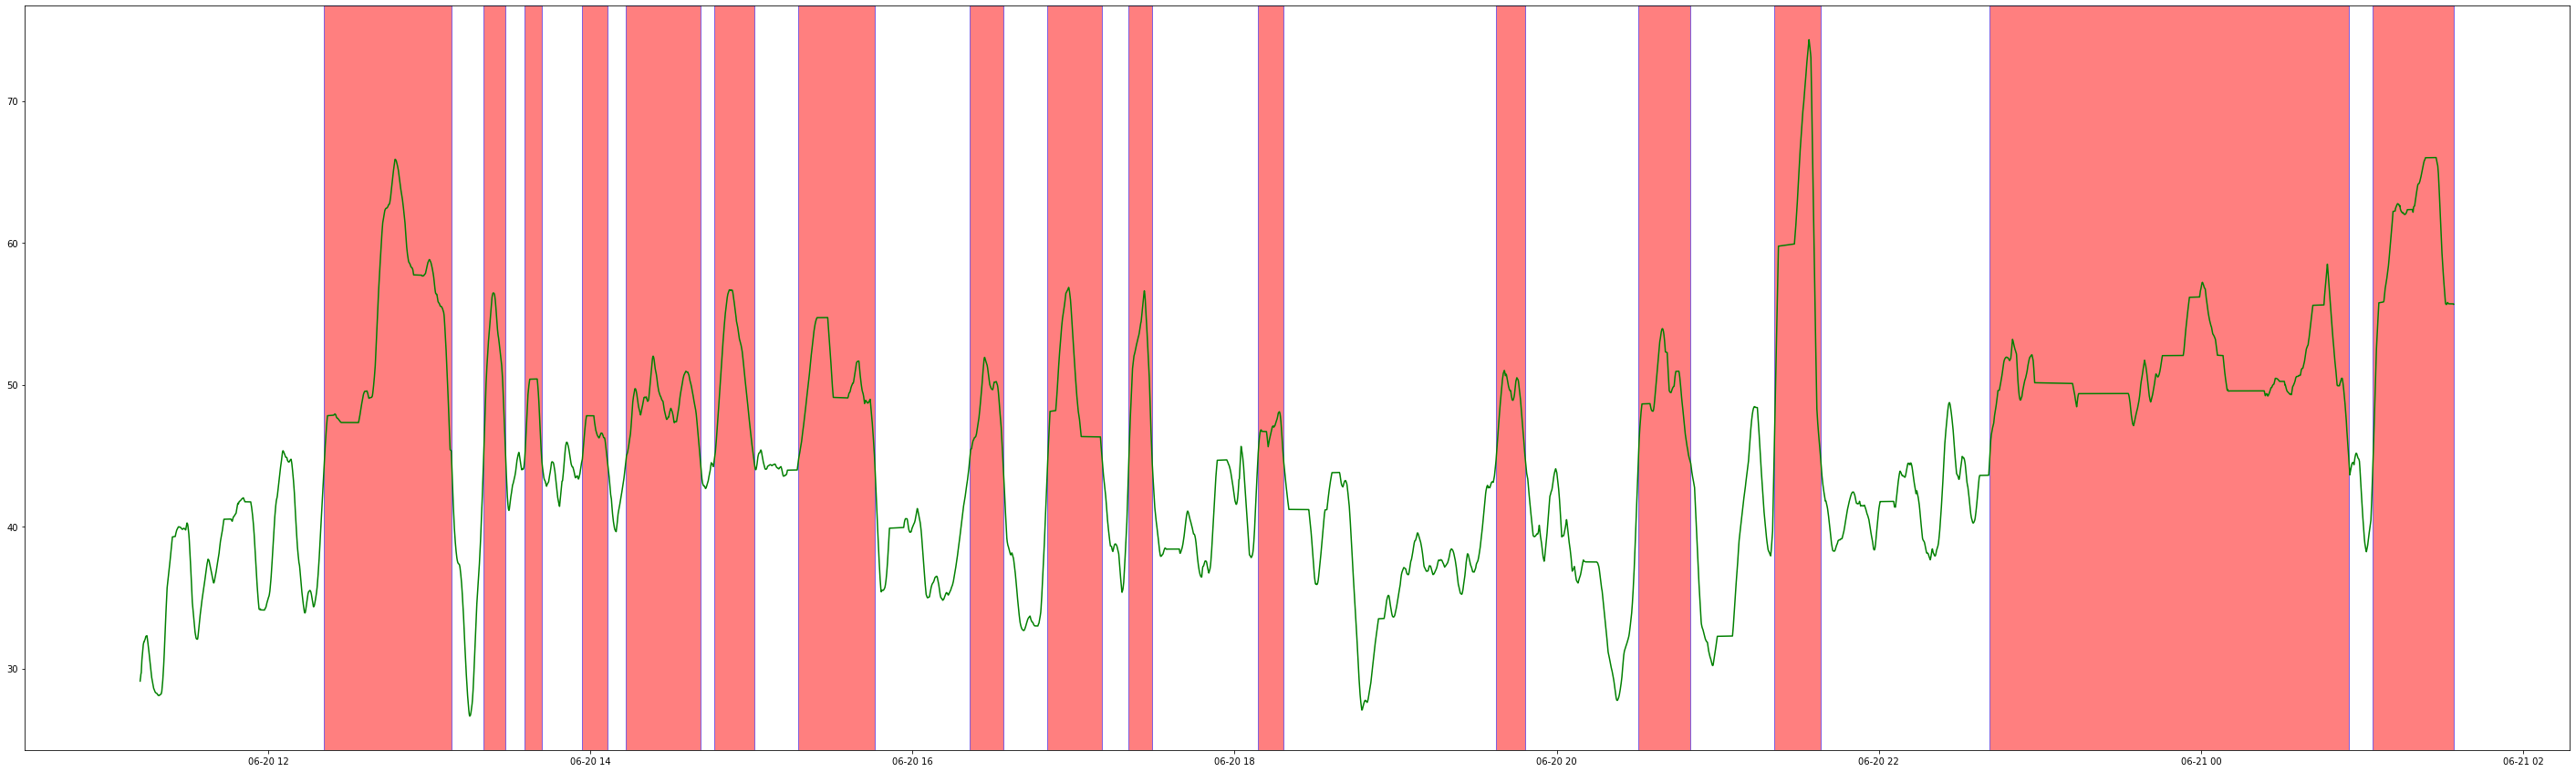

In [36]:
fig = plt.figure(figsize=(70,10))
fig, ax1 = plt.subplots(figsize = (50,15))
# fig, ax1 = plt.subplot()
ax1.plot(hrv_features['datetime'], hrv_features['MAG_K300'], color = 'g')

for d in hrv_events_df.index:
    ax1.axvspan(hrv_events_df['Starting Timestamp'][d], hrv_events_df['Ending Timestamp'][d], facecolor = 'r', edgecolor='b', alpha = 0.5)
ax1.relim()
ax1.autoscale_view()


<Figure size 5040x720 with 0 Axes>

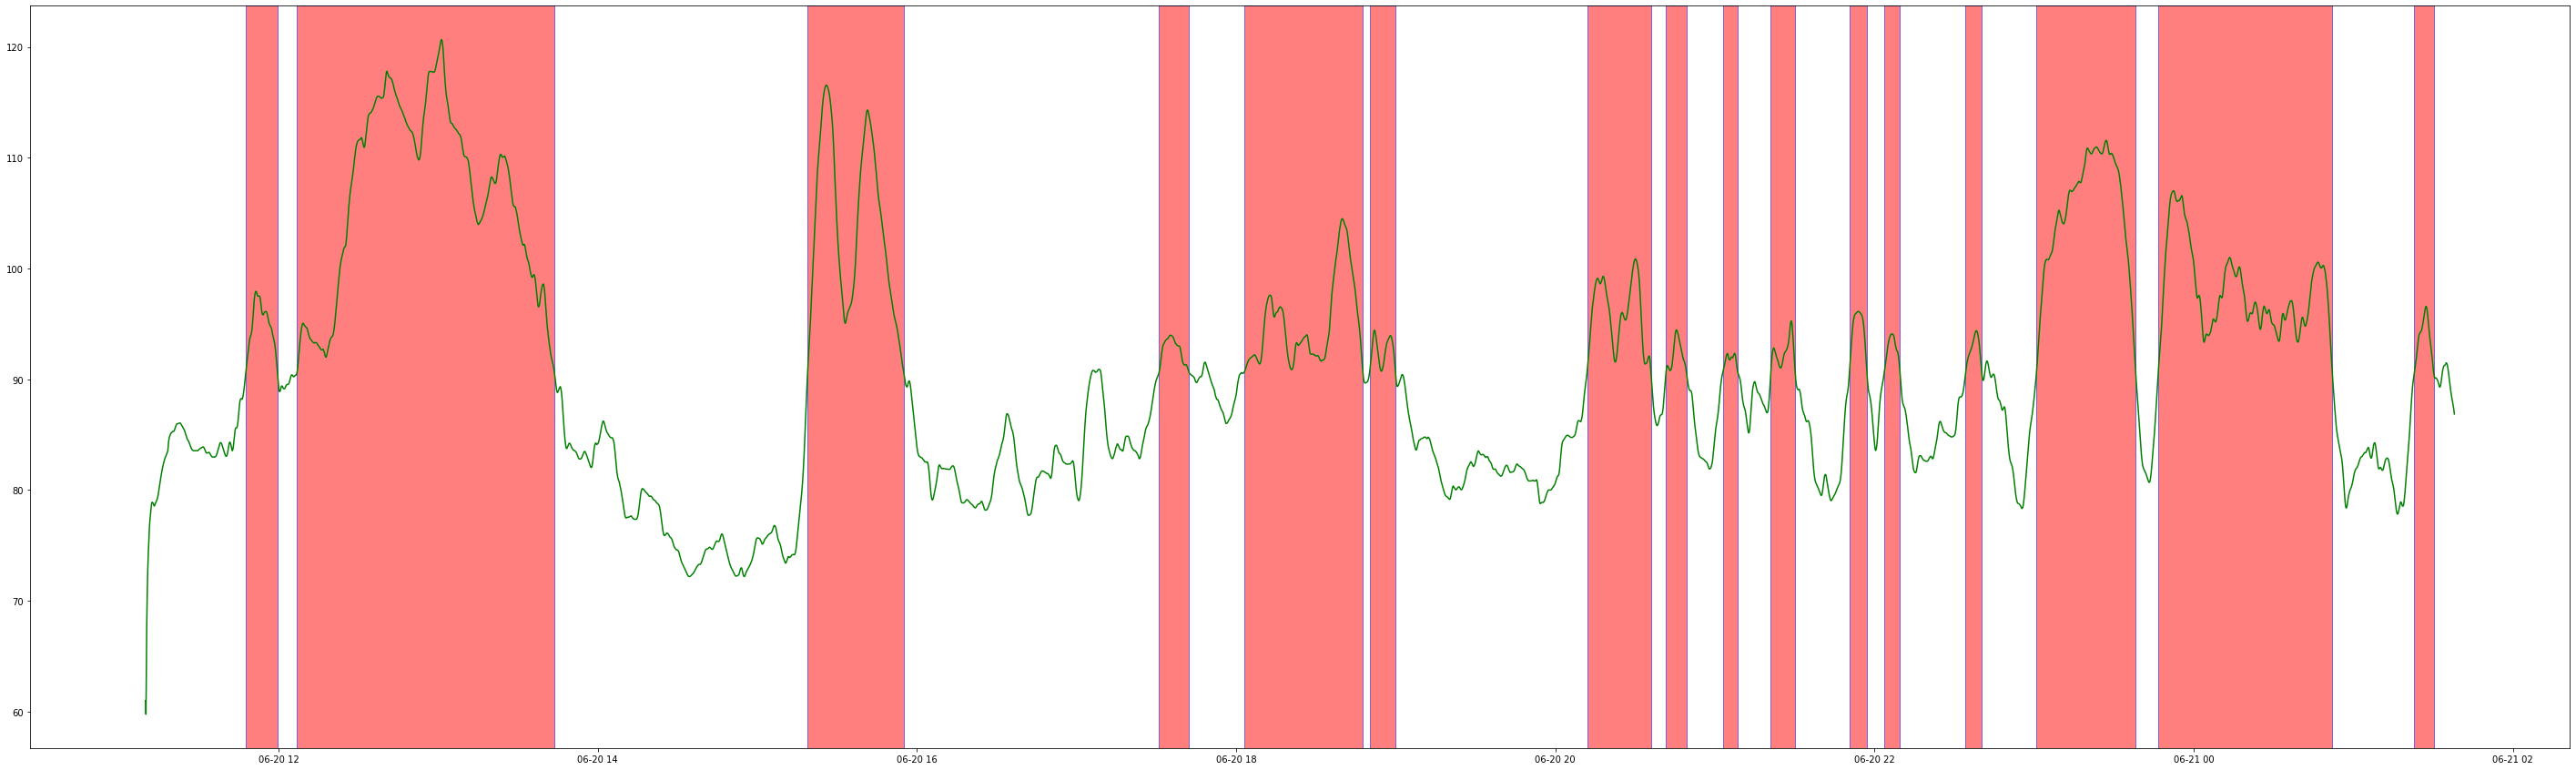

In [37]:
fig = plt.figure(figsize=(70,10))
fig, ax1 = plt.subplots(figsize = (50,15))
# fig, ax1 = plt.subplot()
ax1.plot(hr_df['datetime'], hr_df['MAG_K300'], color = 'g')

for d in hrv_events_df.index:
    ax1.axvspan(hr_events_df['Starting Timestamp'][d], hr_events_df['Ending Timestamp'][d], facecolor = 'r', edgecolor='b', alpha = 0.5)
ax1.relim()
ax1.autoscale_view()

  0%|          | 0/11 [00:00<?, ?it/s]

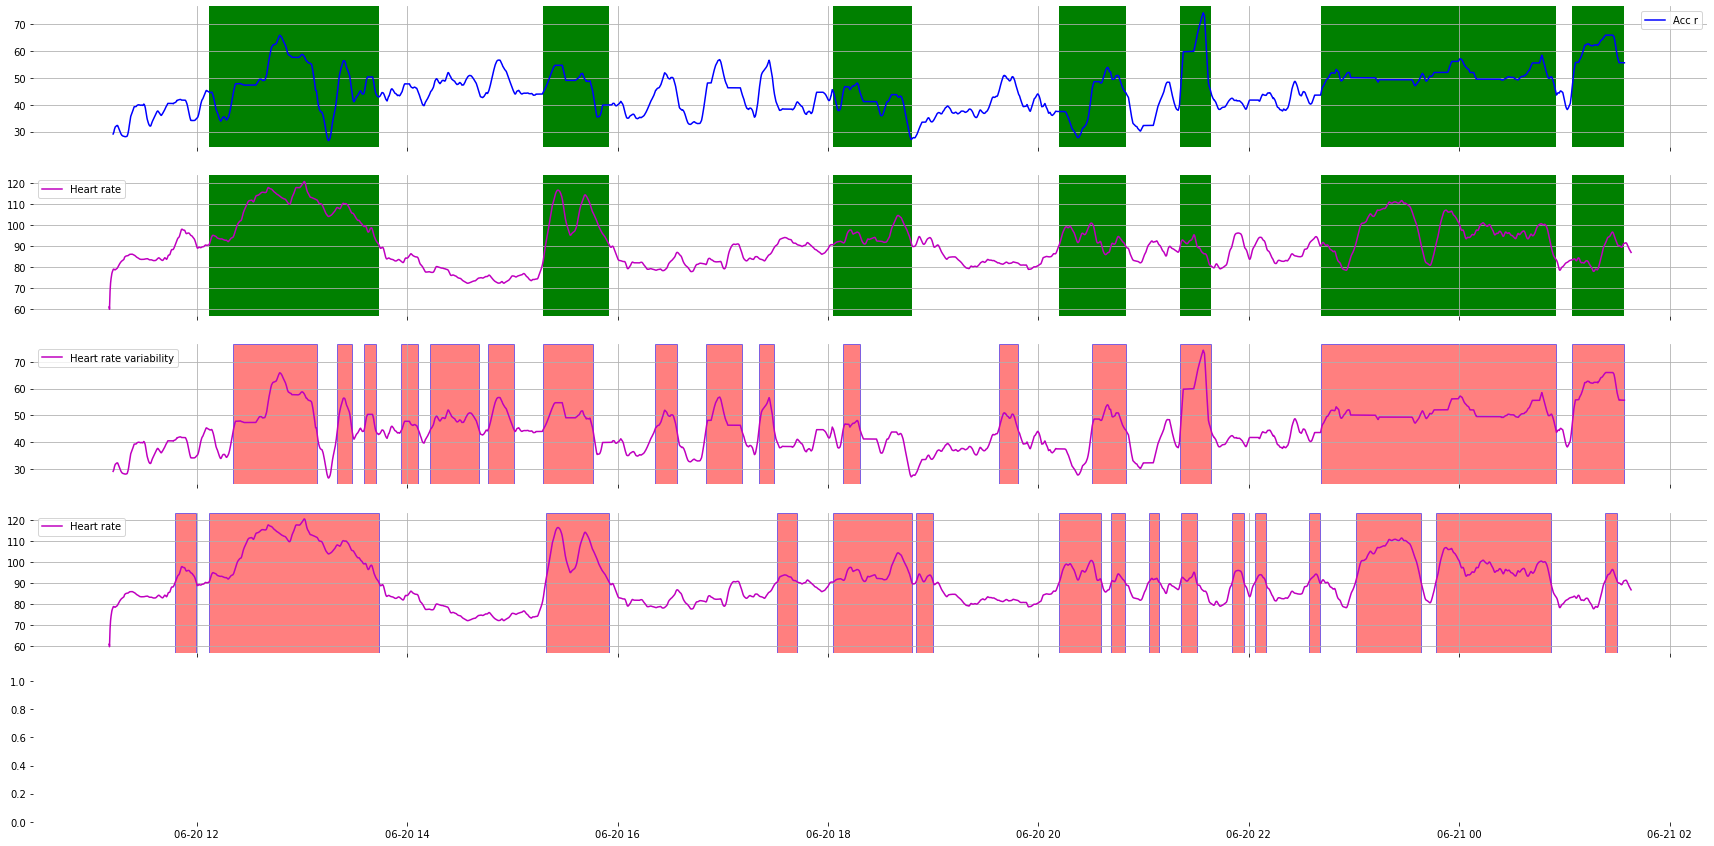

In [38]:
fig, axs = plt.subplots(nrows=5, sharex=True, subplot_kw=dict(
    frameon=False), figsize=(30, 15))  # frameon=False removes frames
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()


axs[0].plot(hrv_features['datetime'], hrv_features['MAG_K300'],
            color='b', label="Acc r")
axs[1].plot(hr_df['datetime'], hr_df['MAG_K300'],
            color='m', label="Heart rate")

axs[2].plot(hrv_features['datetime'], hrv_features['MAG_K300'],
            color='m', label="Heart rate variability")

axs[3].plot(hr_df['datetime'], hr_df['MAG_K300'],
            color='m', label="Heart rate")

for d in tqdm(overlapped_events.index):
    axs[0].axvspan(overlapped_events['Starting Timestamp'][d],
                    overlapped_events['Ending Timestamp'][d], facecolor="g", edgecolor="none", alpha=1)
    
    axs[1].axvspan(overlapped_events['Starting Timestamp'][d],
                overlapped_events['Ending Timestamp'][d], facecolor="g", edgecolor="none", alpha=1)
    
for d in hrv_events_df.index:
    axs[2].axvspan(hrv_events_df['Starting Timestamp'][d], hrv_events_df['Ending Timestamp'][d], facecolor = 'r', edgecolor='b', alpha = 0.5)


for d in hrv_events_df.index:
    axs[3].axvspan(hr_events_df['Starting Timestamp'][d], hr_events_df['Ending Timestamp'][d], facecolor = 'r', edgecolor='b', alpha = 0.5)
        
for i in range(4):
        axs[i].legend()

In [46]:
arr = [1,2,3,4,5,6,7,8,9,10]

for i in range(len(arr)):
    for j in range(len(arr)):
        if(i != j):
            print(arr[i]>arr[j], arr[i]," > ", arr[j])

2  >  1
3  >  1
3  >  2
4  >  1
4  >  2
4  >  3
5  >  1
5  >  2
5  >  3
5  >  4
6  >  1
6  >  2
6  >  3
6  >  4
6  >  5
7  >  1
7  >  2
7  >  3
7  >  4
7  >  5
7  >  6
8  >  1
8  >  2
8  >  3
8  >  4
8  >  5
8  >  6
8  >  7
9  >  1
9  >  2
9  >  3
9  >  4
9  >  5
9  >  6
9  >  7
9  >  8
10  >  1
10  >  2
10  >  3
10  >  4
10  >  5
10  >  6
10  >  7
10  >  8
10  >  9


In [77]:
for i in range(len(concatnated_frames_1)):
    for j in range(len(concatnated_frames_1)):
        check_overlap(concatnated_frames_1.iloc[i], concatnated_frames_1.iloc[j])


TypeError: 'Timestamp' object is not subscriptable